In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')



In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# 1. EDA

In [3]:
DATASET_PATH = 'KP/train.csv'
PREPARED_DATASET_PATH = 'KP/train_prepared.csv'
TEST_DATASET_PATH = 'KP/test.csv'

In [4]:
df = pd.read_csv(DATASET_PATH, sep=',')

In [5]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [7]:
df['Id'] = df['Id'].astype(str)
df['DistrictId'] = df['DistrictId'].astype(str)

In [8]:
df.memory_usage().sum()/1024**2

1.5260009765625

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.82 MB
Decreased by 46.0%


In [11]:
df.dtypes

Id               category
DistrictId       category
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [12]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


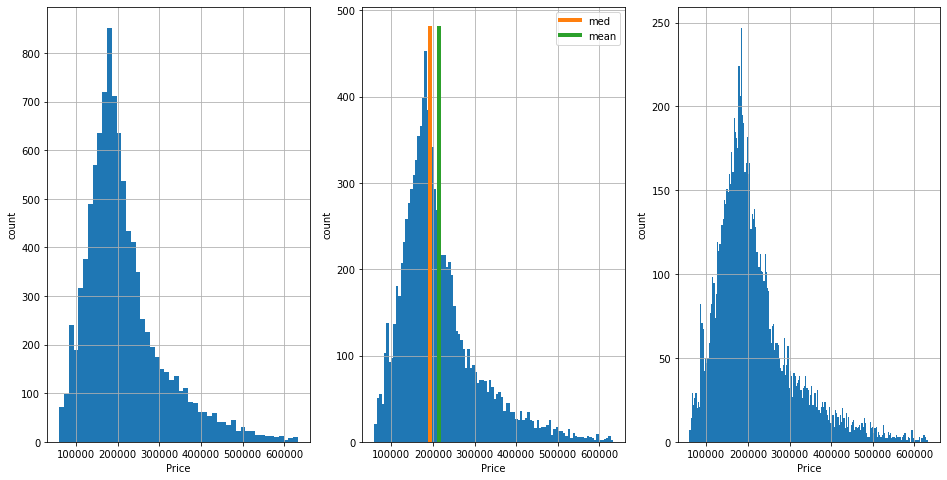

In [13]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
df['Price'].hist(density=False, bins=50)
plt.ylabel('count')
plt.xlabel('Price')
plt.subplot(132)
df['Price'].hist(density=False, bins=100)
plt.ylabel('count')
plt.xlabel('Price')
plt.subplot(133)
df['Price'].hist(density=False, bins=200)
plt.ylabel('count')
plt.xlabel('Price')

target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()

y = np.linspace(0, 480, 10)
plt.subplot(132)
plt.plot([target_median] * 10, y, linewidth=4, label='med')
plt.plot([target_mean] * 10, y, linewidth=4, label='mean')
plt.legend()
plt.show()

In [14]:
# Наблюдается некоторое отклонение по количеству домов в диапазоне цен от 50000 до 100000

In [15]:
# В целом выборка выглядит логичной - много домов дешевых и средней цены, и мало домов дорогих,
# причем количество домов падает быстрее с ростом цены, чем с понижением цены

## 1.1 Количественные переменные

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  category
 1   DistrictId     10000 non-null  category
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [17]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [18]:
# Количество значений в столбцах 'LifeSquare', 'HealthCare' меньше, чем строк в датасете, т.е. в наличии пропуски

## Номинативные переменные

In [19]:
df.select_dtypes(include='category').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [20]:
df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
209      1
174      1
199      1
Name: DistrictId, Length: 205, dtype: int64

In [21]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [22]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [23]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## 2. Обработка выбросов и пропусков

### 2.1 Столбец "Rooms"

In [24]:
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [25]:
df.loc[(df['Rooms']==19), 'Price'] # Проверка стоимости объекта с 19 комнатами

6088    78364.617188
Name: Price, dtype: float32

In [26]:
df['Rooms_outlier'] = 0

In [27]:
# Поиск и замена выбросов 

In [28]:
df.loc[(df['Rooms'] == 0) | (df['Rooms'] > df['Rooms'].quantile(0.99))]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
403,13434,13,5.0,183.382278,100.985504,15.0,2,6.0,1997,0.090799,...,B,74,19083,2,NaN,5,15,B,622888.812500,0
505,3454,8,5.0,112.135521,79.795448,10.0,4,17.0,1999,0.437885,...,B,23,5735,3,1084.0,0,5,B,471833.781250,0
511,8685,62,5.0,124.933289,81.122368,30.0,5,3.0,2017,0.072158,...,B,2,629,1,NaN,0,0,A,271919.875000,0
940,4971,169,5.0,117.855972,76.561317,9.0,12,14.0,2001,0.178917,...,B,18,3594,4,192.0,1,5,B,608674.125000,0
1459,8901,34,5.0,121.577423,114.913841,1.0,25,1.0,1977,0.069753,...,B,53,13670,4,NaN,1,11,B,455446.406250,0
1906,5548,86,5.0,275.645294,233.949310,26.0,12,37.0,2011,0.161976,...,A,31,7010,5,4508.0,3,7,B,455264.875000,0
1909,238,88,5.0,90.762276,70.991791,5.0,1,9.0,1972,0.127376,...,B,43,8429,3,NaN,3,9,B,289683.937500,0
2004,5927,57,10.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,317265.312500,0
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,B,43,8429,3,NaN,3,9,B,158998.109375,0
2516,338,46,5.0,147.709305,NaN,0.0,6,0.0,1977,0.150818,...,B,16,3433,4,2643.0,4,5,B,352168.968750,0


In [29]:
df.loc[(df['Rooms'] == 0) | (df['Rooms'] > df['Rooms'].quantile(0.99)), 'Rooms_outlier'] = 1

In [30]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.875000,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.718750,0
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.000000,0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.093750,0


In [31]:
df.loc[df['Rooms'] == 0, 'Rooms'] = 1

In [32]:
df.loc[df['Rooms'] > df['Rooms'].quantile(0.99), 'Rooms'] = df['Rooms'].median()

### 2.2 'Square'

In [33]:
df['Square'].value_counts()

81.867165    2
37.498161    2
44.482914    2
80.794792    2
65.285133    2
            ..
46.324123    1
43.100792    1
82.824371    1
38.042900    1
43.554482    1
Name: Square, Length: 9995, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

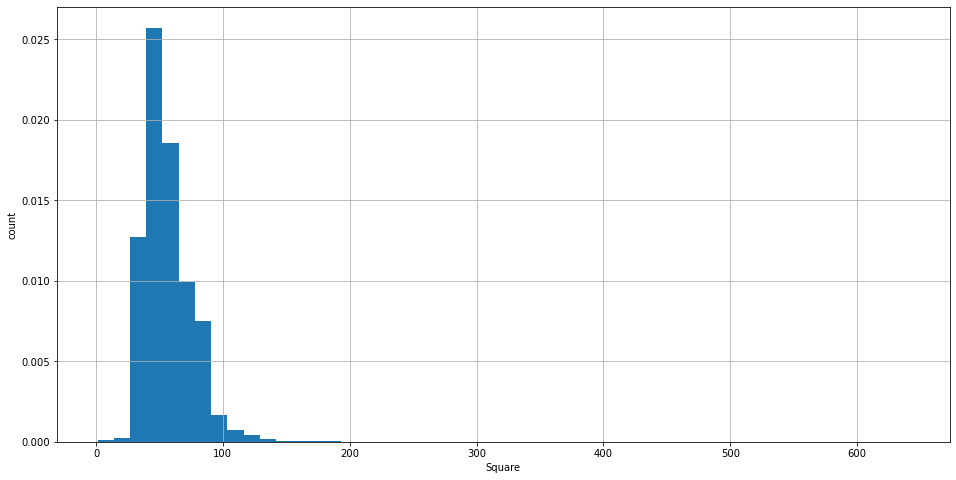

In [34]:
plt.figure(figsize=(16, 8))
plt.subplot(111)
df['Square'].hist(density=True, bins=50)
plt.ylabel('count')
plt.xlabel('Square')
plt.show

In [35]:
df.loc[df['Square'] > 150, ['Square', 'Price']].sort_values(by='Square')

,Square,Price
2066,151.150665,284884.968750
3182,155.930023,559886.937500
730,156.636581,502523.562500
9037,160.647583,217875.000000
6450,162.587891,207407.359375
6030,163.286972,228572.515625
3204,163.495331,207007.953125
5844,167.767029,211180.796875
5764,168.086349,367353.562500
1449,169.117203,211325.578125


<function matplotlib.pyplot.show(close=None, block=None)>

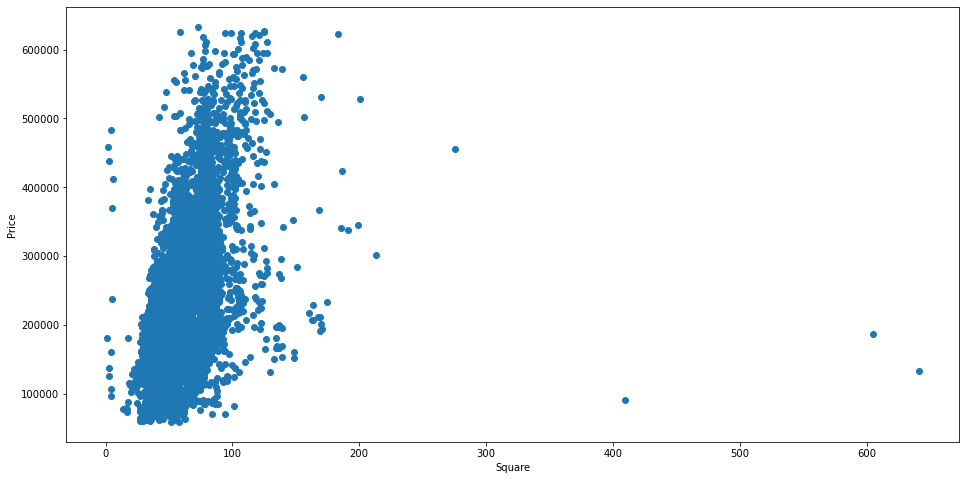

In [36]:
plt.figure(figsize=(16, 8))
plt.subplot(111)
plt.scatter(df['Square'], df['Price'])
plt.ylabel('Price')
plt.xlabel('Square')
plt.show

In [37]:
avg_price_of_sq_meter = df['Price'].sum() / df['Square'].sum()

In [38]:
df.loc[df['Square'] > df['Square'].quantile(0.99), 'Square'] = (1 / (avg_price_of_sq_meter / (df['Price'] / df['Square']))) \
                                                               * df['Square'].median()

In [39]:
# тут мысль такая была - выбросы вернуть в основное облако точек пропорционально средней цене квадратного метра и
# изначальной стоимости "выбросной" квартиры - то есть вычисляем стоимость кв. метра "выбросной квартиры", вычисляем
# во сколько раз она отличается от средней цены квадратного метра по всему датасету, медианную площадь делим на этот
# коэффициент

In [40]:
df.loc[df['Square'] < 9, 'Square'] = df['Square'].median()

<function matplotlib.pyplot.show(close=None, block=None)>

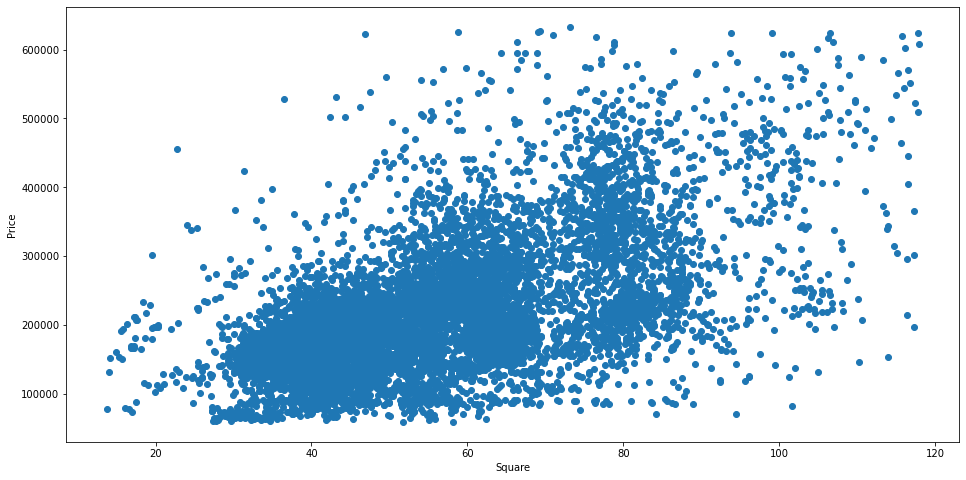

In [41]:
plt.figure(figsize=(16, 8))
plt.subplot(111)
plt.scatter(df['Square'], df['Price'])
plt.ylabel('Price')
plt.xlabel('Square')
plt.show

In [42]:
# идея - добавить признак - цена 1 квадратного метра порайонно

## 2.2 "LifeSquare"

In [43]:
# В данном столбце есть пропуски и нужно проверить, чтобы жилая площадь была не более 0.95 и не менее 0.5 общей площади

In [44]:
condition = (df['LifeSquare'] >= df['Square'] * 0.95) | (df['LifeSquare'] <= df['Square'] * 0.5)

In [45]:
df.loc[condition, ['Id', 'Square', 'LifeSquare']] 

,Id,Square,LifeSquare
8,9951,46.887894,44.628132
12,898,47.564442,23.574423
15,4328,36.673409,16.285522
26,8553,83.262527,4.769175
31,13084,47.837631,22.297739
...,...,...,...
9979,2201,40.043236,41.984322
9982,10268,36.112392,1.855415
9987,11665,62.690056,64.602936
9993,9289,84.486076,88.931511


In [46]:
df.loc[condition, 'LifeSquare'] = df['Square'] * 0.95 

In [47]:
df.loc[[33, 64, 77]]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
33,847,74,2.0,73.314972,69.649223,1.0,7,6.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,254005.37500,0
64,3992,1,3.0,87.200623,82.840591,0.0,21,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,300180.37500,0
77,11771,45,1.0,38.467278,36.543915,1.0,11,9.0,1977,0.195781,...,B,23,5212,6,NaN,3,2,B,247440.53125,0


In [48]:
# Пропуски заполним по общей площади с тем же коэффициентом 0.95

In [49]:
df['LifeSquare'].fillna(df['Square'] * 0.95, inplace=True)

In [50]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outlier
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.882200,55.199696,42.132347,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500,0.003000
std,0.800615,17.176233,16.935812,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438,0.054693
min,1.000000,13.784864,8.822989,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344,0.000000
25%,1.000000,41.636403,30.405044,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906,0.000000
50%,2.000000,52.027189,39.310518,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438,0.000000
75%,2.000000,65.481316,50.474531,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938,0.000000
max,4.000000,117.855972,111.828827,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500,1.000000


## 2.3 'KitchenSquare'

In [51]:
df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560839
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [52]:
# Пропусков нет, есть нулевые значения, и явный выброс по площади

In [53]:
condition = (df['KitchenSquare'] <= 0) |  (df['KitchenSquare'] >= df['Square'])

In [54]:
df.loc[condition, 'KitchenSquare'] = 0.15 * df['Square']

In [55]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outlier
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.882200,55.199696,42.132347,6.443078,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500,0.003000
std,0.800615,17.176233,16.935812,4.717905,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438,0.054693
min,1.000000,13.784864,8.822989,1.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344,0.000000
25%,1.000000,41.636403,30.405044,3.969867,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906,0.000000
50%,2.000000,52.027189,39.310518,7.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438,0.000000
75%,2.000000,65.481316,50.474531,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938,0.000000
max,4.000000,117.855972,111.828827,112.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500,1.000000


## 2.4 Healthcare_1

In [56]:
df.drop('Healthcare_1', axis=1, inplace=True)

In [57]:
df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,109.275948,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,0,0,B,305018.875000,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1,0,B,177734.546875,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,3,1,B,282078.718750,0
3,2352,1,1.0,40.409908,38.389412,1.0,10,22.0,1977,0.007122,B,B,1,264,0,0,1,B,168106.000000,0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,0,6,B,343995.093750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,1,9,B,119367.453125,0
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,0,0,A,199715.156250,0
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,1,5,B,165953.906250,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,3,5,B,171842.406250,0


## 2.5 Floor, HouseFloor

In [58]:
df['Floor'].max()

42

In [59]:
df['Floor'].min()

1

In [60]:
df['HouseFloor'].max()

117.0

In [61]:
df['HouseFloor'].min()

0.0

In [62]:
(df['HouseFloor'] < 1).sum()

269

In [63]:
df.loc[df['HouseFloor'] < 1, 'HouseFloor'] = df['Floor']

In [64]:
(df['HouseFloor'] < 1).sum()

0

In [65]:
df.loc[df['HouseFloor'] < df['Floor'], ['Floor']] = df['HouseFloor'] // 2

In [66]:
(df['Floor'] > df['HouseFloor']).sum()

0

## 2.6 HouseYear

In [67]:
df['HouseYear'].sort_values(ascending=False)
df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [68]:
class DataPreprocessor:
    """Подготовка исходных данных"""
    
    def __init__(self, price):
        """Class parameters"""
        self.room_square_quantile = None
        self.square_quantile = None
        self.medians = None
        self.avg_price_of_sq_meter = None
        self.price = price
        
    def fit(self, X):
        """Statistics saving"""
        self.room_square_quantile = X['Rooms'].quantile(.99)
        self.square_quantile = X['Square'].quantile(.99)
        self.medians = X.median()
        self.avg_price_of_sq_meter = self.price.sum() / X['Square'].sum()
    
    def transform(self, X):
        """Data transform"""
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > X['Rooms'].quantile(0.99)), 'Rooms_outlier'] = 1
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > X['Rooms'].quantile(0.99), 'Rooms'] = self.medians['Rooms']
        
        # Square
        X.loc[X['Square'] > self.square_quantile, 'Square'] = (1 / (self.avg_price_of_sq_meter / (self.price / X['Square']))) \
                                                               * self.medians['Square']
        
        # LifeSquare
        condition = (X['LifeSquare'] >= X['Square'] * 0.95) | (X['LifeSquare'] <= X['Square'] * 0.5)
        X.loc[condition, 'LifeSquare'] = X['Square'] * 0.95
        X['LifeSquare'].fillna(X['Square'] * 0.95, inplace=True)
        
        # KitchenSquare
        condition_kitchen = (X['KitchenSquare'] < 0.15 * X['Square']) |  (X['KitchenSquare'] >= X['Square'])
        X.loc[condition_kitchen, 'KitchenSquare'] = 0.15 * X['Square']
        
        # HealthCare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        
        # Floor, HouseFloor
        X.loc[X['HouseFloor'] < 1, 'HouseFloor'] = X['Floor']
        X.loc[X['HouseFloor'] < X['Floor'], ['Floor']] = X['HouseFloor'] // 2
        
        # HouseYear
        current_year = datetime.now().year
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        X.fillna(self.medians, inplace=True)
        
        return X

# 3 Построение новых признаков

## Dummies

In [69]:
binary_to_numbers = {'A': 0, 'B': 1}

df['Ecology_2'] = df['Ecology_2'].replace(binary_to_numbers)
df['Ecology_3'] = df['Ecology_3'].replace(binary_to_numbers)
df['Shops_2'] = df['Shops_2'].replace(binary_to_numbers)

## mean sq meter price by district

In [70]:
# определить цену 1 квадратного метра порайонно

In [71]:
df['sq_meter_price'] = df['Price'] / df['Square']

In [72]:
mean_sq_meter_price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'sq_meter_price':'mean'})\
                            .rename(columns={'sq_meter_price':'MeanSqMeterPriceByDistrict'})

In [73]:
mean_sq_meter_price_by_district.head()

,DistrictId,MeanSqMeterPriceByDistrict
0,0,3710.401123
1,1,3241.502686
2,10,4377.498047
3,100,5093.929688
4,101,4177.750000


In [74]:
df = df.merge(mean_sq_meter_price_by_district, on=['DistrictId'], how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,sq_meter_price,MeanSqMeterPriceByDistrict
0,11809,27,3.0,115.027313,109.275948,10.0,4.0,10.0,2014,0.075424,...,11,3097,0,0,0,1,305018.875000,0,2651.708252,2871.800049
1,3013,22,1.0,39.832523,23.169222,8.0,7.0,8.0,1966,0.118537,...,30,6207,1,1,0,1,177734.546875,0,4462.045898,3738.867432
2,8215,1,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,0.025609,...,33,5261,0,3,1,1,282078.718750,0,3600.596680,3241.502686
3,2352,1,1.0,40.409908,38.389412,1.0,10.0,22.0,1977,0.007122,...,1,264,0,0,1,1,168106.000000,0,4160.019531,3241.502686
4,13866,94,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,0.282798,...,33,8667,2,0,6,1,343995.093750,0,5351.088867,4194.537109


In [75]:
class FeatureGeneration():
    """Feature Generation"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.mean_sq_meter_price_by_district = None
        self.mean_sq_meter_price_by_district_median = None
         
    def fit(self, X, y=None):     
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            df['sq_meter_price'] = df['Price'] / df['Square']
            df = df.groupby(['DistrictId'], as_index=False).agg({'sq_meter_price':'mean'})\
                                                    .rename(columns={'sq_meter_price':'MeanSqMeterPriceByDistrict'})
            df.head()
            self.mean_sq_meter_price_by_district = df
            self.mean_sq_meter_price_by_district_median = self.mean_sq_meter_price_by_district['MeanSqMeterPriceByDistrict'].median()
        
    def transform(self, X):
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers) 
        
        # mean sq meter price by district
        if self.mean_sq_meter_price_by_district is not None:
            X = X.merge(self.mean_sq_meter_price_by_district, on=['DistrictId'], how='left')
            X['MeanSqMeterPriceByDistrict'].fillna(self.mean_sq_meter_price_by_district_median, inplace=True)
        
        return X
    
    

# 4 Отбор признаков

In [76]:
df.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'sq_meter_price',
 'MeanSqMeterPriceByDistrict']

In [77]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

In [78]:
new_feature_names = ['Rooms_outlier', 'MeanSqMeterPriceByDistrict']

In [79]:
target_name = 'Price'

# 5. Разбиение на train и test 

In [80]:
train_df = pd.read_csv(DATASET_PATH)

In [81]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [82]:
X = train_df.drop(columns=target_name)

In [83]:
y = train_df[target_name]

In [84]:
X

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B


In [85]:
y

0       305018.871089
1       177734.553407
2       282078.720850
3       168106.007630
4       343995.102962
            ...      
9995    119367.455796
9996    199715.148807
9997    165953.912580
9998    171842.411855
9999    177685.627486
Name: Price, Length: 10000, dtype: float64

In [86]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=47)

In [87]:
preprocessor = DataPreprocessor(y_train)

In [88]:
preprocessor.fit(X_train)

In [89]:
X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

In [90]:
X_train.shape, X_valid.shape, test_df.shape

((6700, 19), (3300, 19), (5000, 19))

In [91]:
features_gen = FeatureGeneration()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 20), (3300, 20), (5000, 20))

In [92]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,MeanSqMeterPriceByDistrict
0,4567,44,1.0,36.847630,19.094182,5.527145,5.0,9.0,1970,0.036122,1,1,24,4378,0,1,1,1,0,4479.183926
1,5925,62,1.0,42.493907,40.369212,10.000000,7.0,17.0,2017,0.072158,1,1,2,629,1,0,0,0,0,3082.911036
2,960,27,2.0,59.463678,56.490494,9.000000,19.0,19.0,1977,0.211401,1,1,9,1892,0,0,1,1,0,3015.821394
3,3848,23,3.0,49.646030,33.893825,7.446904,2.0,2.0,1965,0.014073,1,1,2,475,0,0,0,1,0,2450.205922
4,746,74,1.0,53.837056,51.145203,8.075558,8.0,17.0,1977,0.309479,1,1,35,7715,4,0,6,1,0,3414.405910


In [93]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [94]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [95]:
X_train.shape

(6700, 18)

In [96]:
X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,MeanSqMeterPriceByDistrict
0,1.0,39.692662,21.620983,9.000000,24.0,25.0,2007,0.012339,1,1,35,5776,1,2,4,1,0,3974.831205
1,1.0,47.694143,45.309436,7.154121,13.0,18.0,2017,0.017647,1,1,2,469,0,0,0,1,0,3015.821394
2,1.0,36.459935,23.906201,9.000000,11.0,12.0,1971,0.319809,1,1,25,4756,16,5,8,1,0,4516.565751
3,2.0,44.457828,31.520388,6.668674,3.0,9.0,1974,0.309479,1,1,35,7715,4,0,6,1,0,4050.778081
4,2.0,47.889416,29.316856,7.183412,4.0,9.0,1981,0.219006,1,1,28,6746,3,1,4,1,0,3946.955588


# 6 Построение модели

In [97]:
rf_model = RandomForestRegressor(random_state=47, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=47)

Train R2:	0.961
Test R2:	0.734


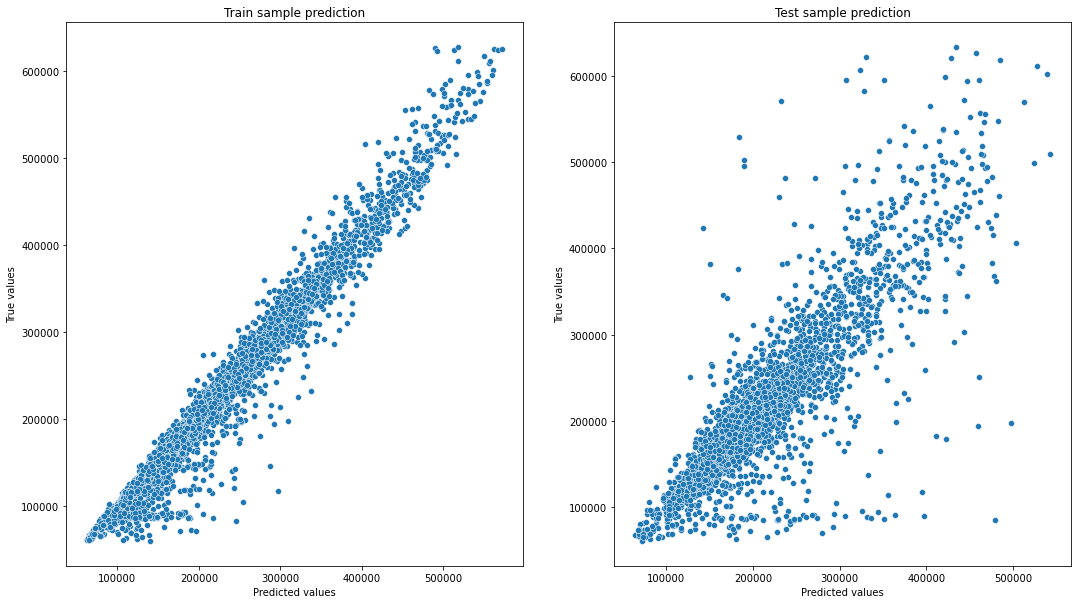

In [98]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [99]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72644452, 0.69972266, 0.71310316])

In [100]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.350891
17,MeanSqMeterPriceByDistrict,0.310958
0,Rooms,0.061340
3,KitchenSquare,0.046957
2,LifeSquare,0.043250
6,HouseYear,0.034850
12,Social_3,0.022899
10,Social_1,0.021808
5,HouseFloor,0.021434
11,Social_2,0.021239


# 7 Прогнозирование на тестовом датасете

In [102]:
test_df.shape

(5000, 18)

In [103]:
submit = pd.read_csv('KP/sample_submission.csv')

In [104]:
submit

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0
...,...,...
4995,10379,200000.0
4996,16138,200000.0
4997,3912,200000.0
4998,5722,200000.0


In [105]:
predictions = rf_model.predict(test_df)
predictions

array([159031.69154439, 115480.6704307 , 132452.03467794, ...,
       148383.91609539, 186313.71971702, 227764.22622297])

In [106]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,159031.691544
1,5925,115480.670431
2,960,132452.034678
3,3848,132931.646795
4,746,177805.526794


In [107]:
submit.to_csv('KP/rf_submit.csv', index=False)